<a href="https://colab.research.google.com/github/skj092/Kaggle_Competition/blob/main/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the dataset and Setting up Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!touch kaggle.json 

In [3]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
!chmod 600 /content/kaggle.json 

In [5]:
# Downloading the dataset
!kaggle competitions download -c dog-breed-identification

 97% 671M/691M [00:05<00:00, 151MB/s]
100% 691M/691M [00:05<00:00, 142MB/s]


In [6]:
!mkdir input-data

In [7]:
!unzip -q dog-breed-identification.zip -d input-data

# Importing the libraries and EDA

In [9]:
!pip install wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.7 MB/s eta 0:00:00


In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import *
import timm 

In [2]:
path = Path('/content/input-data')
Path.BASE_PATH = path
path.ls()

(#4) [Path('train'),Path('labels.csv'),Path('sample_submission.csv'),Path('test')]

In [3]:
labels = pd.read_csv(path/'labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
print('shape of the dataset', labels.shape)
print('total unique breed', labels.breed.nunique())

shape of the dataset (10222, 2)
total unique breed 120


In [5]:
print('total number of images per breed')
labels['breed'].value_counts()

total number of images per breed


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

`images per class vary and also the images are very less `

# Dataset and DataLoader

In [6]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x = ColReader(0, pref=path/'train', suff='.jpg'),
                   get_y=ColReader(1), 
                   splitter=RandomSplitter(),
                   item_tfms=Resize(460, method="squeeze"),
                   batch_tfms=[*aug_transforms(size=300),Normalize.from_stats(*imagenet_stats)])

In [7]:
dls = dblock.dataloaders(labels)

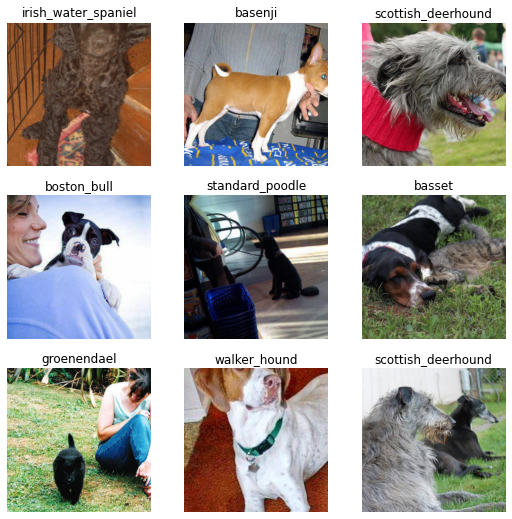

In [8]:
# show one batch
dls.show_batch()

# Modelling

In [9]:
# experimentation on subser of dataset
df = labels.sample(frac=1)
print('df shape', df.shape)
dls = dblock.dataloaders(df)

df shape (10222, 2)


In [10]:
# # setting up wandb for tracking 
import wandb
wandb.init(project="dog-breed-identification")

wandb: Currently logged in as: skj092. Use `wandb login --relogin` to force relogin


# model

In [ ]:
# vision leaner
learn = vision_learner(dls, resnet34, metrics=accuracy,cbs=WandbCallback()).to_fp16()
# training
learn.fine_tune(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.print_classification_report()

# prediction on Test Dataloader

In [ ]:
test_df = pd.read_csv(path/'sample_submission.csv')

In [ ]:
test_df.head()

In [ ]:
# creating test dataloader
test_dl = learn.dls.test_dl(get_image_files(path/'test'))

In [ ]:
preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_files = get_image_files(path/"test")
test_dl = dls.test_dl(test_files, bs=64)

In [ ]:
preds, targs = learn.get_preds(dl=test_dl)

In [ ]:
sub = pd.DataFrame({"id":test_files.map(lambda x:x.stem)})
sub[list(dls.vocab)] = preds
sub.to_csv("submission.csv", index=False)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()

# Submission

In [32]:
!kaggle competitions submit -c dog-breed-identification -f /content/submission.csv -m "resnet34-augmentation"

100% 16.4M/16.4M [00:00<00:00, 40.6MB/s]
Successfully submitted to Dog Breed Identification